# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [52]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs

# import torch.optim as optim
# import torch.nn.functional as F

def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../data'
embeddings_path = '../word_embeddings'


In [2]:
if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda:0'

print(DEVICE)

cuda:0


In [3]:
h_params = {
    'model': 'None'
    , 'batch_size': 128
    , 'embedding_dimensions': 50
}

In [4]:
# Download the pre-trained model for word_embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip 1/glove.6B.zip

## Raw Data

### Loading

Load the data into pandas dataframes

In [5]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [6]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'label', 'label_y': 'label_detailed'})

train_data = train_data.drop('par_id', axis=1)
test_data = test_data.drop('par_id', axis=1)

In [7]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'is_patronizing'] = 0
train_data.loc[train_data['label'].isin([2,3,4]), 'is_patronizing'] = 1

In [22]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

## Pre-Processing

In [23]:
class LabelledDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        # instead of label and label_detailed we use is_patronizing
        label = {'is_patronizing': self.data['is_patronizing'].iloc[idx]}

        return data, label
    
class WithheldDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        return data

train_loader = DataLoader(dataset=LabelledDataset(train_data), batch_size=h_params['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=WithheldDataset(train_data), batch_size=h_params['batch_size'], shuffle=True)

In [12]:
# # Define Embedding Class
# class Encoder(nn.Module):
#     def __init__(self, vocab_size, embedding_dimension):
#         super(Encoder, self)
#         # create embedding object to store mappings from words to embedded vectors
#         self.tokenEmbeddings = nn.Embedding(num_embeddings=vocab_size
#                                           , embedding_dim=embedding_dimension
#                                           , padding_idx=0)
    
#     def forward(self, x):
#         """Generates the embeddings for each word in the input, of size: (batch_size, max_length of training sample)"""
#         embedded = self.embedding(x)
#         embedded = embedded.unsqueeze(1)

#         return embedded

## Data Splits

split the data whilst keeping distributions of country, text and is_patronizing counts even

In [45]:
X = train_data['text']
y = train_data['is_patronizing']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8374,)
y_train shape: (8374,)
X_test shape: (2094,)
y_test shape: (2094,)


## Model

In [145]:

task1_model_args = ClassificationArgs(num_train_epochs=10,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing = False,               # otherwise for me it doesn't run at all
                                      use_multiprocessing_for_evaluation = False # otherwise for me it doesn't run at all
                                      )

task1_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = task1_model_args,
                                  num_labels=2,
                                  use_cuda=DEVICE)

# train model
task1_model.train_model(pd.concat([X_train, y_train], axis=1))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/.venv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Epoch 10 of 10: 100%|██████████| 10/10 [14:36<00:00, 87.66s/it]


(10470, 0.3116169809537238)

In [146]:
# run predictions
y_pred, _ = task1_model.predict(X_test.tolist())

100%|██████████| 21/21 [00:02<00:00,  7.17it/s]


[Text(0, 0.5, 'Not Patronizing'), Text(0, 1.5, 'Patronizing')]

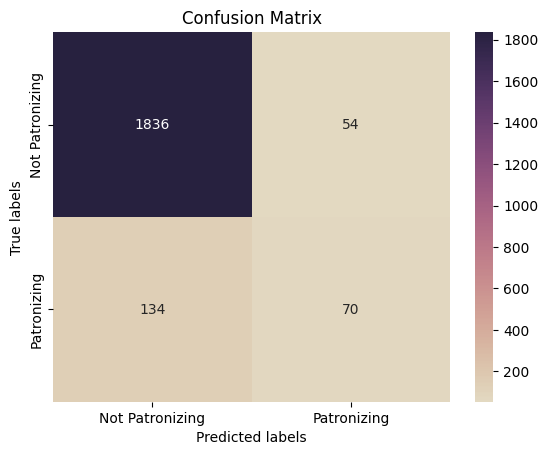

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

set(y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1]) 

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True));  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])

In [148]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1890
           1       0.56      0.34      0.43       204

    accuracy                           0.91      2094
   macro avg       0.75      0.66      0.69      2094
weighted avg       0.90      0.91      0.90      2094



In [163]:
# Get one random sample from the test data
random_index = X_test.sample(n=1).index.values[0]

while random_index not in train_data.index:
    random_index = X_test.sample(n=1).index.values[0]

# Extract random sample
tdf = train_data.loc[[random_index]][['text', 'is_patronizing']]
test_paragraph, real_label = tdf['text'].values[0], tdf['is_patronizing'].values[0]

# Get model prediction
predicted_label, raw_outputs = task1_model.predict([tdf['text'].values[0]])
# predicted_label = task1_model.predict(tdf['text'].values[0])

print(f"=== Paragraph example ===\n{test_paragraph.capitalize()}")
print(f"\tReal Label:      {real_label}")
print(f"\tModel Prediction:{predicted_label[0]}")

100%|██████████| 1/1 [00:00<00:00, 163.20it/s]

=== Paragraph example ===
The common thieves then stole a crust of bread , the law came down upon the hungry heads ; the haughty land robber stole land with men resources and all contents . the first they said were a hopeless conviction . while they escaped the law by trick ; that grave , one-sided justice would not do -- the poor call for consideration , too . the cruel people started the unholy war , then from the line of action they kept far ; they pushed to the front sons of the poor , there to do battle , die , suffer galore , as the guns raged , liberty loans they raised , and in glorious tones , we sung freedom 's praise . those who made wars should first went to the front , and of shot and shell bear there the brunt : in first lines of action they were all due , if to their country and people they were true : when this was demanded in right of all , there would have been no more deadly cannon balls : the downtrodden poor people of us joined together and prevented the pakistani 

## Submission Documents

In [168]:
def get_and_save_predictions(dataset, save_name, model=task1_model):
    y_pred, _ = model.predict(dataset.tolist())
    np.savetxt(f'{save_name}.txt', y_pred, fmt='%d')

# train predictions
get_and_save_predictions(test_data['text'], "test")

# test predictions
get_and_save_predictions(train_data['text'], "dev")

100%|██████████| 105/105 [00:14<00:00,  7.18it/s]
